## Preparation

In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

In [2]:
device=torch.device('cpu') #先調1再調0

In [3]:
print(torch.cuda.is_available())

True


In [4]:
x=torch.randn(1000, 6724)
x=x.to(device)

## Functions

In [31]:
def laplacian(A):
    L=torch.zeros(6400).to(device)
    for i in range(6400):
        #NORTH BOUND
        if i<80:
            A_N=A[i]
        else:
            A_N=A[i-80]
        
        #SOUTH BOUND
        if i>=6320:
            A_s=A[i]
        else:
            A_S=A[i+80]
        
        #WEST BOUND
        if i%80==0:
            A_W=A[i]
        else:
            A_W=A[i-1]
        
        #EAST BOUND
        if i%80==79:
            A_E=A[i]
        else:
            A_E=A[i+1]
            
        L[i]=(A_E+A_W+A_N+A_S-4*A[i])*80*80
            
    return L

In [32]:
def LAPLACIAN(A):
    size=A.size(dim=0)
    LP=torch.rand(size,6400).to(device)
    for i in range(size):
        LP[i]=laplacian(x[i]);
    return LP

## Data

In [5]:
# Step 1. Prepare data-1/2
# DataLoader wraps a Dataset and provides minibatches, shuffling, multithreading, for you
data_in=np.loadtxt('./data/preserved/input_div_U_2_1s.dat')
data_out=np.loadtxt('./data/preserved/input_div_U_2_1s.dat')
x=torch.Tensor(data_in)
y=torch.Tensor(data_out)
x=x.to(device)
y=y.to(device)
#x=x[:8000]
#y=y[:8000]
print(x.size())
print(y.size())

torch.Size([1000, 6400])
torch.Size([1000, 6400])


In [6]:
loader=DataLoader(TensorDataset(x, y), batch_size=100)

## Model

In [7]:
# Step 2. Create model 建立model習慣建立class
class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, B, D_out):
        super(TwoLayerNet, self).__init__()
        self.linear_1=torch.nn.Linear(D_in, H)
        self.linear_2=torch.nn.Linear(H, B)
        self.linear_3=torch.nn.Linear(B, D_out)
    
    # Step 3. Forward pass-1/2    # Step 4. Backward pass-1/2
    def forward(self, x):
        h=self.linear_1(x)
        h_relu=torch.nn.functional.relu(h) #為何activation and hidden layer 的實現方式不同
        b=self.linear_2(h_relu) 
        b_relu=torch.nn.functional.relu(b)
        y_pred=self.linear_3(b_relu) 
        return y_pred
    
model= TwoLayerNet(D_in=6400, H=100, B=100, D_out=6400)
model=model.to(device) #這行是什麼意思? A:将模型加载到相应的设备

In [ ]:
x= torch.nn.Sequential(torch.nn.Unflatten(1, (1,82,82)))(x)
# Convolutional neural network (two convolutional layers)
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(torch.nn.Module):
    def __init__(self, channel_1, channel_2, kernel_dim):
        super(ConvNet, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, channel_1, kernel_dim)
        self.conv2 = nn.Conv2d(channel_1, channel_2, kernel_dim)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(78*78*3, 1000)  # 78*78 from image dimension
        self.fc2 = nn.Linear(1000, 1000)
        self.fc3 = nn.Linear(1000, 6724)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = ConvNet(channel_1=3, channel_2=3, kernel_dim=3).to(device)

## Training

In [8]:
tol=1e-6

In [26]:
optimizer=torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

In [13]:
optimizer=torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)

In [14]:
loss_epoch=[]
loss_values = []
loss=1
epochs=0

print("Epochs    Loss")

while(loss>tol):
    epochs=epochs+1
    scheduler.step()
    
    for x_batch, y_batch in loader:
        # Forward pass
        y_pred=model(x_batch)
        loss=torch.nn.functional.mse_loss(y_pred, x_batch)
        
        # Backward pass
        loss.backward()
        
        # Update Weights
        optimizer.step()
        optimizer.zero_grad()
    
    loss_epoch.append(epochs)
    loss_values.append(loss.item())
    
    if epochs%1==0:
        print("Epochs: ", epochs, "; Loss: ", loss.item())
        
    loss=loss.item()

print(epochs, "    ", loss.item())

#Plot loss function
from matplotlib import pyplot as plt
plt.plot(loss_epoch, loss_values)
plt.xlabel('epochs')
plt.ylabel('loss')

Epochs    Loss
Epochs:  1 ; Loss:  1.7399985154042952e-05


C:\Users\ENCHOU\anaconda3\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epochs:  2 ; Loss:  1.3697972462978214e-05
Epochs:  3 ; Loss:  8.849404366628733e-06
Epochs:  4 ; Loss:  1.446726582798874e-05
Epochs:  5 ; Loss:  8.618169886176474e-06
Epochs:  6 ; Loss:  5.025449354434386e-06
Epochs:  7 ; Loss:  6.419735200324794e-06
Epochs:  8 ; Loss:  5.211821644479642e-06
Epochs:  9 ; Loss:  4.037653980049072e-06
Epochs:  10 ; Loss:  4.03575995733263e-06
Epochs:  11 ; Loss:  3.933365860575577e-06
Epochs:  12 ; Loss:  3.826093234238215e-06
Epochs:  13 ; Loss:  3.3024034564732574e-06
Epochs:  14 ; Loss:  3.139458158329944e-06
Epochs:  15 ; Loss:  3.385075160622364e-06
Epochs:  16 ; Loss:  3.5205587209929945e-06
Epochs:  17 ; Loss:  4.202689069643384e-06
Epochs:  18 ; Loss:  4.838638233195525e-06
Epochs:  19 ; Loss:  5.93602953813388e-06
Epochs:  20 ; Loss:  6.980882062634919e-06
Epochs:  21 ; Loss:  8.124308806145564e-06
Epochs:  22 ; Loss:  8.560796231904533e-06
Epochs:  23 ; Loss:  1.0320790352125186e-05
Epochs:  24 ; Loss:  1.2485555089369882e-05
Epochs:  25 ; Lo

Epochs:  190 ; Loss:  1.1898210686922539e-05
Epochs:  191 ; Loss:  1.5479527064599097e-05
Epochs:  192 ; Loss:  1.7141079297289252e-05
Epochs:  193 ; Loss:  1.367845652566757e-05
Epochs:  194 ; Loss:  9.88284227787517e-06
Epochs:  195 ; Loss:  8.70131862029666e-06
Epochs:  196 ; Loss:  1.0255761480948422e-05
Epochs:  197 ; Loss:  1.3089145795674995e-05
Epochs:  198 ; Loss:  1.4467029359366279e-05
Epochs:  199 ; Loss:  1.308751234319061e-05
Epochs:  200 ; Loss:  1.120632623496931e-05
Epochs:  201 ; Loss:  1.1471560355857946e-05
Epochs:  202 ; Loss:  1.1031327630917076e-05
Epochs:  203 ; Loss:  1.0452435162733309e-05
Epochs:  204 ; Loss:  9.507381037110463e-06
Epochs:  205 ; Loss:  9.05999604583485e-06
Epochs:  206 ; Loss:  1.0298409506503958e-05
Epochs:  207 ; Loss:  1.1119771443190984e-05
Epochs:  208 ; Loss:  1.010735195450252e-05
Epochs:  209 ; Loss:  8.575636456953362e-06
Epochs:  210 ; Loss:  7.341164291574387e-06
Epochs:  211 ; Loss:  7.686036951781716e-06
Epochs:  212 ; Loss:  9.

Epochs:  376 ; Loss:  8.795548637863249e-06
Epochs:  377 ; Loss:  7.479297892132308e-06
Epochs:  378 ; Loss:  8.584122042520903e-06
Epochs:  379 ; Loss:  1.0796323294925969e-05
Epochs:  380 ; Loss:  1.2456243894121144e-05
Epochs:  381 ; Loss:  1.1752754289773293e-05
Epochs:  382 ; Loss:  8.156884177878965e-06
Epochs:  383 ; Loss:  5.908186722081155e-06
Epochs:  384 ; Loss:  5.8114187595492695e-06
Epochs:  385 ; Loss:  9.634864909457974e-06
Epochs:  386 ; Loss:  1.2555668035929557e-05
Epochs:  387 ; Loss:  1.2251272892171983e-05
Epochs:  388 ; Loss:  9.522062100586481e-06
Epochs:  389 ; Loss:  6.952736384846503e-06
Epochs:  390 ; Loss:  7.659367838641629e-06
Epochs:  391 ; Loss:  1.242279449797934e-05
Epochs:  392 ; Loss:  1.4729968825122342e-05
Epochs:  393 ; Loss:  1.216567943629343e-05
Epochs:  394 ; Loss:  8.418061042902991e-06
Epochs:  395 ; Loss:  7.83656560088275e-06
Epochs:  396 ; Loss:  1.0625281902321149e-05
Epochs:  397 ; Loss:  1.3625473002321087e-05
Epochs:  398 ; Loss:  1.

Epochs:  562 ; Loss:  5.325258825905621e-06
Epochs:  563 ; Loss:  4.98586905450793e-06
Epochs:  564 ; Loss:  4.17385172113427e-06
Epochs:  565 ; Loss:  3.169136562064523e-06
Epochs:  566 ; Loss:  3.0676421829411993e-06
Epochs:  567 ; Loss:  3.6461203762883088e-06
Epochs:  568 ; Loss:  4.981503025192069e-06
Epochs:  569 ; Loss:  6.280946763581596e-06
Epochs:  570 ; Loss:  6.762966677342774e-06
Epochs:  571 ; Loss:  6.639558705501258e-06
Epochs:  572 ; Loss:  5.643496479024179e-06
Epochs:  573 ; Loss:  5.534273441298865e-06
Epochs:  574 ; Loss:  5.495478035300039e-06
Epochs:  575 ; Loss:  7.580234068882419e-06
Epochs:  576 ; Loss:  9.716793101688381e-06
Epochs:  577 ; Loss:  1.092651018552715e-05
Epochs:  578 ; Loss:  1.095475545298541e-05
Epochs:  579 ; Loss:  9.46987984207226e-06
Epochs:  580 ; Loss:  9.298451004724484e-06
Epochs:  581 ; Loss:  9.97773531707935e-06
Epochs:  582 ; Loss:  1.2890738616988529e-05
Epochs:  583 ; Loss:  1.4889014892105479e-05
Epochs:  584 ; Loss:  1.48819717

Epochs:  748 ; Loss:  6.5547337726457044e-06
Epochs:  749 ; Loss:  5.808161859022221e-06
Epochs:  750 ; Loss:  5.309216703608399e-06
Epochs:  751 ; Loss:  4.386703494674293e-06
Epochs:  752 ; Loss:  3.875444235745817e-06
Epochs:  753 ; Loss:  3.917125468433369e-06
Epochs:  754 ; Loss:  4.178475592198083e-06
Epochs:  755 ; Loss:  5.447640887723537e-06
Epochs:  756 ; Loss:  5.835423053213162e-06
Epochs:  757 ; Loss:  6.580699391633971e-06
Epochs:  758 ; Loss:  6.554074388986919e-06
Epochs:  759 ; Loss:  5.395765128923813e-06
Epochs:  760 ; Loss:  4.537742825050373e-06
Epochs:  761 ; Loss:  4.270373210601974e-06
Epochs:  762 ; Loss:  6.010145170876058e-06
Epochs:  763 ; Loss:  8.250326573033817e-06
Epochs:  764 ; Loss:  9.58731925493339e-06
Epochs:  765 ; Loss:  8.348570190719329e-06
Epochs:  766 ; Loss:  6.448357453336939e-06
Epochs:  767 ; Loss:  5.289911314321216e-06
Epochs:  768 ; Loss:  6.263049726840109e-06
Epochs:  769 ; Loss:  8.543442163500004e-06
Epochs:  770 ; Loss:  1.07724945

Epochs:  935 ; Loss:  4.754459951072931e-06
Epochs:  936 ; Loss:  5.448859155876562e-06
Epochs:  937 ; Loss:  5.341257747204509e-06
Epochs:  938 ; Loss:  4.647441528504714e-06
Epochs:  939 ; Loss:  4.0474201341567095e-06
Epochs:  940 ; Loss:  3.998879037681036e-06
Epochs:  941 ; Loss:  4.419255219545448e-06
Epochs:  942 ; Loss:  5.217508260102477e-06
Epochs:  943 ; Loss:  5.338483788364101e-06
Epochs:  944 ; Loss:  5.495949153555557e-06
Epochs:  945 ; Loss:  5.171892553335056e-06
Epochs:  946 ; Loss:  4.65362063550856e-06
Epochs:  947 ; Loss:  5.0189823923574295e-06
Epochs:  948 ; Loss:  5.844557108503068e-06
Epochs:  949 ; Loss:  6.987906090216711e-06
Epochs:  950 ; Loss:  7.003989139775513e-06
Epochs:  951 ; Loss:  6.230900908121839e-06
Epochs:  952 ; Loss:  5.426069037639536e-06
Epochs:  953 ; Loss:  5.4573042689298745e-06
Epochs:  954 ; Loss:  6.962888619455043e-06
Epochs:  955 ; Loss:  8.166712177626323e-06
Epochs:  956 ; Loss:  8.977657671493944e-06
Epochs:  957 ; Loss:  8.450531

AttributeError: 'float' object has no attribute 'item'

## Result

[]

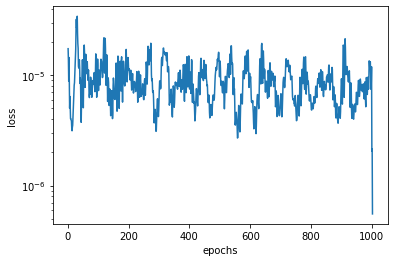

In [15]:
#Plot loss function
from matplotlib import pyplot as plt
plt.plot(loss_epoch, loss_values)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.semilogy()

## Export

In [1]:
device=torch.device('cpu')
model=model.to(device)
PATH= "model_jit_cvspy.pth"
traced_net=torch.jit.trace(model, (torch.randn(1,6400)).to(device))
traced_net.to(torch.float64)
torch.jit.save(traced_net, PATH)

NameError: name 'torch' is not defined

In [18]:
PATH= "model_cvspy.pth"
torch.save(model.state_dict(), PATH)